#Import dataset from drive (Zip File)

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!unzip gdrive/My\ Drive/Frood_Drive/D_12.zip

#Main process

In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

In [17]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    '/content/D_12',
    color_mode='rgb',
    label_mode = 'categorical',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='training',
)
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    '/content/D_12',
    color_mode='rgb',
    label_mode = 'categorical',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='validation',
)

Found 23347 files belonging to 12 classes.
Using 18678 files for training.
Found 23347 files belonging to 12 classes.
Using 4669 files for validation.


In [18]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 2)
validation_dataset = validation_dataset.skip(val_batches // 2)

In [19]:
class_names = train_dataset.class_names

print('Number of training batches: %d' % tf.data.experimental.cardinality(train_dataset).numpy())
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset).numpy())
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset).numpy())

Number of training batches: 584
Number of validation batches: 73
Number of test batches: 73


In [20]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [21]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

IMG_SHAPE = (224,224) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [22]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
base_model.trainable = False

In [23]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

In [24]:
prediction_layer = tf.keras.layers.Dense(12, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)

In [25]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [27]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                  

In [28]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

73/73 [==============================] - 10s 61ms/step - loss: 3.0201 - accuracy: 0.0952
initial loss: 3.02
initial accuracy: 0.10


In [29]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
584/584 [==============================] - 50s 80ms/step - loss: 1.0333 - accuracy: 0.6915 - val_loss: 0.3662 - val_accuracy: 0.9366
Epoch 2/10
584/584 [==============================] - 46s 78ms/step - loss: 0.2891 - accuracy: 0.9371 - val_loss: 0.1892 - val_accuracy: 0.9649
Epoch 3/10
584/584 [==============================] - 46s 78ms/step - loss: 0.1787 - accuracy: 0.9614 - val_loss: 0.1334 - val_accuracy: 0.9747
Epoch 4/10
584/584 [==============================] - 46s 78ms/step - loss: 0.1294 - accuracy: 0.9721 - val_loss: 0.1035 - val_accuracy: 0.9769
Epoch 5/10
584/584 [==============================] - 46s 78ms/step - loss: 0.1024 - accuracy: 0.9771 - val_loss: 0.0828 - val_accuracy: 0.9807
Epoch 6/10
584/584 [==============================] - 46s 78ms/step - loss: 0.0869 - accuracy: 0.9795 - val_loss: 0.0736 - val_accuracy: 0.9820
Epoch 7/10
584/584 [==============================] - 46s 78ms/step - loss: 0.0735 - accuracy: 0.9827 - val_loss: 0.0630 - val_accuracy:

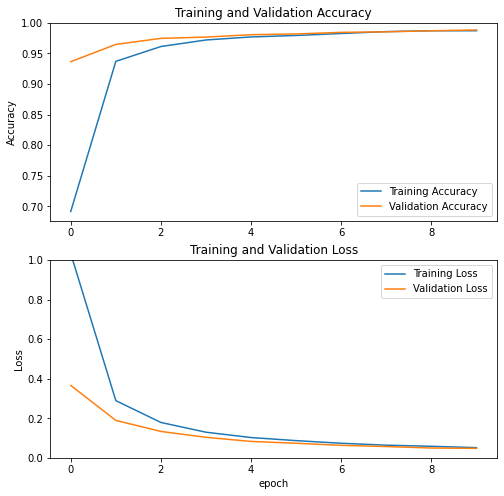

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine tuning for better result

In [31]:
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [32]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [33]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                  

In [34]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/15
584/584 [==============================] - 58s 94ms/step - loss: 0.0314 - accuracy: 0.9898 - val_loss: 0.0163 - val_accuracy: 0.9957
Epoch 11/15
584/584 [==============================] - 52s 88ms/step - loss: 0.0126 - accuracy: 0.9961 - val_loss: 0.0063 - val_accuracy: 0.9983
Epoch 12/15
584/584 [==============================] - 51s 87ms/step - loss: 0.0081 - accuracy: 0.9973 - val_loss: 0.0062 - val_accuracy: 0.9983
Epoch 13/15
584/584 [==============================] - 51s 87ms/step - loss: 0.0043 - accuracy: 0.9988 - val_loss: 0.0027 - val_accuracy: 0.9991
Epoch 14/15
584/584 [==============================] - 51s 87ms/step - loss: 0.0039 - accuracy: 0.9992 - val_loss: 0.0105 - val_accuracy: 0.9961
Epoch 15/15
584/584 [==============================] - 51s 87ms/step - loss: 0.0028 - accuracy: 0.9993 - val_loss: 0.0012 - val_accuracy: 1.0000


In [35]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

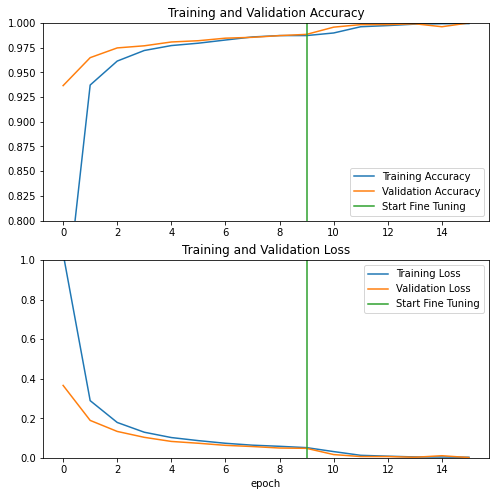

In [36]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Test Model Performance with test set

In [37]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

73/73 [==============================] - 10s 126ms/step - loss: 0.0106 - accuracy: 0.9983
Test accuracy : 0.9982876777648926


Predictions:
 [3, 0, 11, 1, 7, 5, 8, 1, 7, 9, 0, 2, 10, 11, 8, 1, 1, 10, 8, 3, 9, 3, 11, 1, 2, 8, 5, 9, 4, 6, 10, 1]
Labels:
 [3, 0, 11, 1, 7, 5, 8, 1, 7, 9, 0, 2, 10, 11, 8, 1, 1, 10, 8, 3, 9, 3, 11, 1, 2, 8, 5, 9, 4, 6, 10, 1]


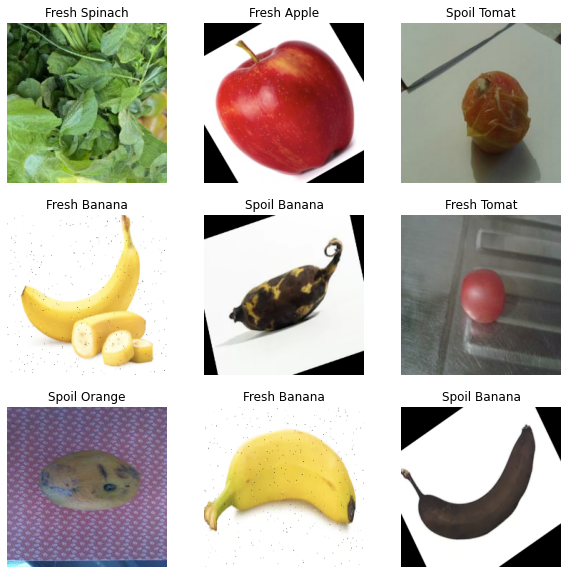

In [41]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

predictions = tf.nn.softmax(predictions)
predictions = list(np.argmax(x) for x in predictions.numpy())

print('Predictions:\n', predictions)
print('Labels:\n', list(np.argmax(x) for x in label_batch))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

#Try Model With Custom Single Image

In [45]:
img = image.load_img(path='/content/bayams2.jpg', target_size=(224,224))
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
result = model.predict(img)
print(np.round_(result*100, decimals=2))

y_pred = np.argmax(result, axis=1)
print(y_pred)
if y_pred[0] == 0:
    print("Fresh Apple")
elif y_pred[0] == 1:
    print("Fresh Banana")
elif y_pred[0] == 2:
    print("Fresh Orange")
elif y_pred[0] == 3:
    print("Fresh Spinach")
elif y_pred[0] == 4:
    print("Fresh Strawberry")
elif y_pred[0] == 5:
    print("Fresh Tomato")
elif y_pred[0] == 6:
    print("Spoil Apple")
elif y_pred[0] == 7:
    print("Spoil Banana")
elif y_pred[0] == 8:
    print("Spoil Orange")
elif y_pred[0] == 9:
    print("Spoil Spinach")
elif y_pred[0] == 10:
    print("Spoil Strawberry")
elif y_pred[0] == 11:
    print("Spoil Tomato")

[[0.000e+00 1.000e-02 0.000e+00 1.300e-01 0.000e+00 0.000e+00 0.000e+00
  2.000e-02 0.000e+00 9.984e+01 0.000e+00 0.000e+00]]
[9]
Spoil Spinach


#Save Model

In [46]:
model.save('/content/Model_12_Class_Acc99.h5')